In [1]:
import os
import sys
import torch
import numpy as np
import onnxruntime as ort
from transformers import BertTokenizer
from sklearn.naive_bayes import GaussianNB
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset

current_notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_notebook_dir, '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from data_helpers import get_topic_data, display_topic_data, process_text, extract_new_tokens
from ml_helpers import train_test_loop, split_data
from model_creation.schemas.topics import topic_to_index, index_to_topic

c:\.Work\projects\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def map_label_to_class(label):
  try: 
    return topic_to_index[label]
  except: raise ValueError(f"Label '{label}' not found in any source categories.")

def process_data(df):
  df['text'] = df['text'].apply(process_text)
  df.drop(columns=['id'])
  return df

def pytorch_to_numpy(loader):
  inputs_array = []
  labels_array = []
  for inputs, labels in loader:
    inputs_batch = inputs.cpu().numpy()
    labels_batch = labels.cpu().numpy()

    for input in inputs_batch:
      inputs_array.append(input)
    for label in labels_batch:
      labels_array.append(label)
  return inputs_array, labels_array

In [3]:
# dataset initialization
class TopicData(Dataset):
  def __init__(self,df,device):
    df.drop(columns=['id'])
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    self.data = df
    self.device = device
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    text = self.data['text'][idx]
    label = map_label_to_class(self.data['topic'][idx])
    vectorized_text = self.tokenizer(
      text,
      return_tensors='pt',
      truncation=True,
      )
    input = vectorized_text['input_ids'].squeeze(0)
    return input.to(self.device),torch.tensor(label).to(self.device)

In [4]:
# model
class TopicClassificationModel(nn.Module):
  def __init__(self,input_size,embed_dim,hidden_dim_1,num_class):
    super(TopicClassificationModel,self).__init__()
    self.embed = nn.EmbeddingBag(input_size,embed_dim)
    self.fc1 = nn.Linear(embed_dim, hidden_dim_1)
    self.fc2 = nn.Linear(hidden_dim_1, num_class)
    self.relu = nn.LeakyReLU()
  
  def forward(self,text):
    embed = self.embed(text)
    output = self.relu(self.fc1(embed))
    output = self.fc2(output)
    return F.softmax(output,dim=1)

In [5]:
# predict
def predict_text(text,session,dataset):
  text = process_text(text)
  vectorized_text = dataset.tokenizer(
      text,
      return_tensors='np',
      truncation=True,
      )
  onnx_input = {
    'input' : vectorized_text['input_ids'].astype(np.int32)
  }
  output = session.run(None,onnx_input)[0][0]
  prediction = output.argmax()

  prediction = index_to_topic.get(prediction, 'Prediction error.')
  probabilities_percentage = [f"{p * 100:.1f}%" for p in output]

  print(f'The text provided leans towards {prediction} with probabilities of: ')
  for index, name in index_to_topic.items():
    print(f'{probabilities_percentage[index]} for {name}')

topic
business     71
food        100
gaming      100
politics    158
sport       100
tech         21
Name: count, dtype: int64


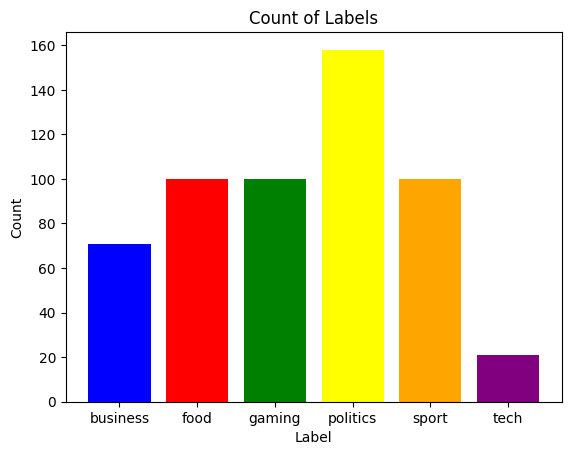

cuda
Training Classification NN Starting


100%|██████████| 44/44 [00:00<00:00, 46.55it/s]


Training Epoch [1/10], Loss: 0.1776, Accuracy: 0.2182


100%|██████████| 11/11 [00:00<00:00, 152.04it/s]


Test Epoch [1/10], Loss: 0.1750, Accuracy: 0.3545


100%|██████████| 44/44 [00:00<00:00, 90.33it/s]


Training Epoch [2/10], Loss: 0.1759, Accuracy: 0.2568


100%|██████████| 11/11 [00:00<00:00, 152.62it/s]


Test Epoch [2/10], Loss: 0.1741, Accuracy: 0.3000


100%|██████████| 44/44 [00:00<00:00, 88.18it/s]


Training Epoch [3/10], Loss: 0.1741, Accuracy: 0.2909


100%|██████████| 11/11 [00:00<00:00, 166.74it/s]


Test Epoch [3/10], Loss: 0.1730, Accuracy: 0.3091


100%|██████████| 44/44 [00:00<00:00, 89.88it/s]


Training Epoch [4/10], Loss: 0.1721, Accuracy: 0.3045


100%|██████████| 11/11 [00:00<00:00, 149.95it/s]


Test Epoch [4/10], Loss: 0.1700, Accuracy: 0.3727


100%|██████████| 44/44 [00:00<00:00, 88.69it/s]


Training Epoch [5/10], Loss: 0.1680, Accuracy: 0.3455


100%|██████████| 11/11 [00:00<00:00, 151.81it/s]


Test Epoch [5/10], Loss: 0.1669, Accuracy: 0.3636


100%|██████████| 44/44 [00:00<00:00, 88.19it/s]


Training Epoch [6/10], Loss: 0.1656, Accuracy: 0.3795


100%|██████████| 11/11 [00:00<00:00, 151.18it/s]


Test Epoch [6/10], Loss: 0.1649, Accuracy: 0.3909


100%|██████████| 44/44 [00:00<00:00, 90.87it/s]


Training Epoch [7/10], Loss: 0.1628, Accuracy: 0.4295


100%|██████████| 11/11 [00:00<00:00, 162.45it/s]


Test Epoch [7/10], Loss: 0.1669, Accuracy: 0.3818


100%|██████████| 44/44 [00:00<00:00, 87.66it/s]


Training Epoch [8/10], Loss: 0.1581, Accuracy: 0.5318


100%|██████████| 11/11 [00:00<00:00, 169.47it/s]


Test Epoch [8/10], Loss: 0.1635, Accuracy: 0.4182


100%|██████████| 44/44 [00:00<00:00, 91.71it/s]


Training Epoch [9/10], Loss: 0.1525, Accuracy: 0.5682


100%|██████████| 11/11 [00:00<00:00, 162.78it/s]


Test Epoch [9/10], Loss: 0.1734, Accuracy: 0.2545


100%|██████████| 44/44 [00:00<00:00, 93.41it/s]


Training Epoch [10/10], Loss: 0.1488, Accuracy: 0.5909


100%|██████████| 11/11 [00:00<00:00, 162.42it/s]


Test Epoch [10/10], Loss: 0.1582, Accuracy: 0.4909
Model Saved - Training Done, Final Testing Results Are As Shown:
Training Epoch [10/10], Loss: 0.1488, Accuracy: 0.5909
Test Epoch [10/10], Loss: 0.1582, Accuracy: 0.4909


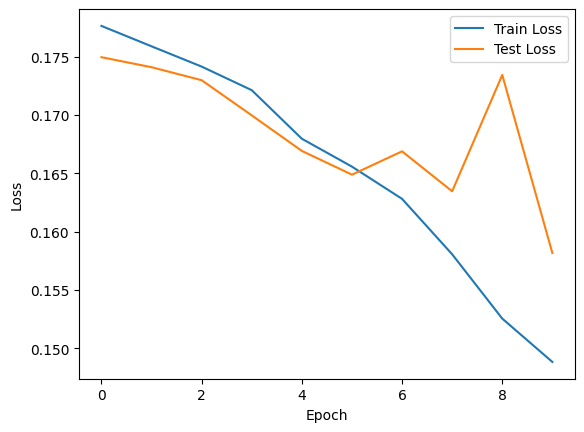

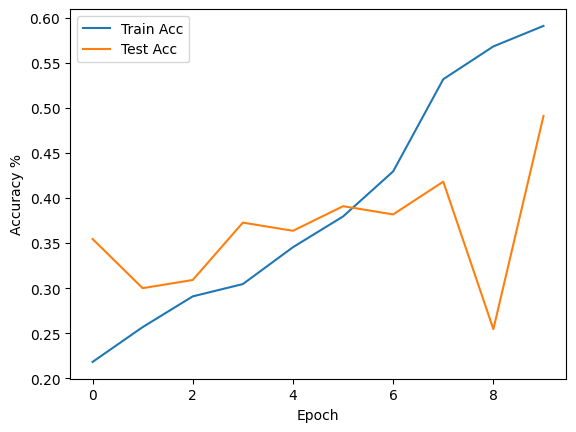

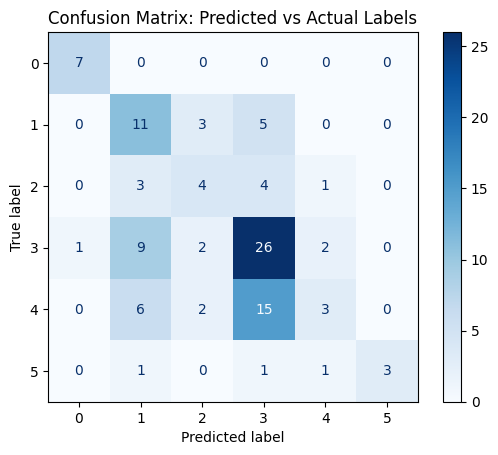

NoSuchFile: [ONNXRuntimeError] : 3 : NO_SUCHFILE : Load model from ../models/topic_model_0.4000.onnx failed:Load model ../models/topic_model_0.4000.onnx failed. File doesn't exist

In [6]:
def main(text, batch_size, num_epochs, verbose, override, skl):
  device = ('cuda' if torch.cuda.is_available() else 'cpu')

  nn_path = '../models/topic'
  
  df = get_topic_data()
  df = process_data(df)

  if (override and verbose):
    display_topic_data(df)
    print(device)

  dataset = TopicData(df,device)
  train_loader, test_loader = split_data(dataset,batch_size)
  if override:
    if skl: 
      batch_size = len(df)
      inputs_array, labels_array = pytorch_to_numpy(train_loader)
      test_inputs_array, test_label_array = pytorch_to_numpy(test_loader)
      gnb = GaussianNB()
      model = gnb.fit(inputs_array,labels_array)
      pred = model.predict(test_inputs_array)
      print("Number of mislabeled points out of a total %d points : %d"
          % (len(test_inputs_array), (test_label_array != pred).sum()))
      #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
    else:
      input_size = dataset.tokenizer.vocab_size
      embed_dim = 256
      hidden_dim_1 = 64
      num_classes = len(topic_to_index)
      model = TopicClassificationModel(input_size,embed_dim,hidden_dim_1,num_classes).to(device)
      if(override or not os.path.exists(nn_path)):
        optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-5)
        criterion = torch.nn.CrossEntropyLoss()
        train_test_loop(nn_path,device,train_loader,test_loader,num_epochs,model,optimizer,criterion,verbose)  

  model_path = '../models/topic_model_0.4000.onnx'
  session = ort.InferenceSession(model_path)
  if(text is not None):
    predict_text(text,session,dataset)

main('sports sports sports', batch_size=10, num_epochs=10, verbose=True, override=True, skl=False)